## 1. Imports & chargement


In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [30]:
# imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# config et chemins
cfg_path = Path("config.yaml")
import yaml
cfg = yaml.safe_load(open(cfg_path))
inter_dir = Path(cfg["paths"]["data"]["interim"])
processed_dir = Path(cfg["paths"]["data"]["processed"])
processed_dir.mkdir(parents=True, exist_ok=True)

# liste des zones
zones = [p.stem.replace("_interim_hourly","")
         for p in inter_dir.glob("*_interim_hourly.pkl")]


In [31]:
print(zones)

['Baleares', 'Canarias', 'Ceuta', 'El_Hierro', 'Gran_canaria', 'Lanzarote_Fuerteventura', 'La_Gomera', 'La_Palma', 'Melilla', 'nacional', 'Peninsule_Iberique', 'Tenerife']


## 2. Degrés-jours (HDD/CDD)

In [4]:
# fonctions HDD / CDD
def add_degree_days(df, base_temp=18.0):
    df["HDD"] = np.maximum(0, base_temp - df["temperature_2m"])
    df["CDD"] = np.maximum(0, df["temperature_2m"] - base_temp)
    return df


## 3. Indices de confort

In [5]:
def compute_heat_index(T, RH):
    # formule simplifiée de Rothfusz (approx)
    return -8.7847 + 1.6114*T + 2.3385*RH - 0.1461*T*RH \
           - 0.0123*T**2 - 0.0164*RH**2 + 0.0022*T**2*RH \
           + 0.0007*T*RH**2 - 0.0000*T**2*RH**2

def add_comfort_indices(df):
    df["HeatIndex"] = compute_heat_index(df["temperature_2m"],
                                         df["relative_humidity_2m"])
    # Wind Chill si T<=10°C et vent>4.8km/h (conversion m/s→km/h*)
    v_kmh = df["wind_speed_10m"] * 3.6
    df["WindChill"] = np.where(
        (df["temperature_2m"] <= 10) & (v_kmh > 4.8),
        13.12 + 0.6215*df["temperature_2m"] - 11.37*v_kmh**0.16
        + 0.3965*df["temperature_2m"]*v_kmh**0.16,
        df["temperature_2m"]
    )
    return df


## 4. Fenêtres glissantes météo et prix

In [6]:
# rolling windows pour variables clés
def add_rolling_features(df):
    windows = [3, 6, 12, 24, 7, 14, 30, 365]  # en heures ou jours
    for w in windows:
        df[f"temp_rmean_{w}"] = df["temperature_2m"].rolling(w).mean()
        df[f"pvpc_rmean_{w}"] = df["pvpc"].rolling(w).mean()
        df[f"rad_rsum_{w}"]   = df["shortwave_radiation"].rolling(w).sum()
    # quelques lags supplémentaires déjà en 02, on peut en ajouter
    return df


## 5. Encodages cycliques et calendaires

In [8]:
# encodages cycliques et saisons
def add_cyclic_time_features(df):
    idx = df.index
    df["hour"]    = idx.hour
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

    df["dayofweek"]  = idx.dayofweek
    df["dow_sin"]    = np.sin(2*np.pi*df["dayofweek"]/7)
    df["dow_cos"]    = np.cos(2*np.pi*df["dayofweek"]/7)

    df["month"]   = idx.month
    df["mth_sin"] = np.sin(2*np.pi*(df["month"]-1)/12)
    df["mth_cos"] = np.cos(2*np.pi*(df["month"]-1)/12)

    df["season"] = ((idx.month % 12 + 3)//3).astype(int)  # 1=hiver,2=printemps…
    return df


## 6. Interactions et transformations non linéaires

In [9]:
# interactions
def add_interactions(df):
    df["T_x_RH"]  = df["temperature_2m"] * df["relative_humidity_2m"]
    df["T_sq"]    = df["temperature_2m"]**2
    df["pvpc_x_T"] = df["pvpc"] * df["temperature_2m"]
    return df


## 7. Sélection de features

In [11]:
# mutual information et importance simple
def select_features(df, target="demand", top_k=20):
    X = df.drop(columns=[target]).fillna(0)
    y = df[target].values
    mi = mutual_info_regression(X, y, discrete_features=False)
    mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    return mi_s.head(top_k)



lag_1h                 1.600281
lag_24h                1.531520
lag_168h               1.197296
dayofyear              0.467779
rmean_7d               0.428900
temperature_2m         0.426535
hour                   0.366263
rstd_7d                0.357574
month                  0.306536
shortwave_radiation    0.228729
dtype: float64

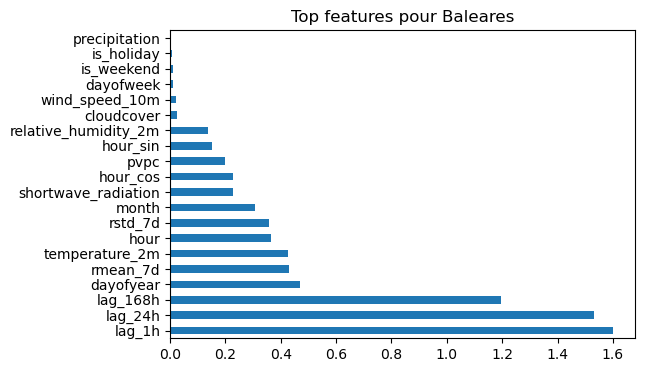

In [32]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_hourly.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

lag_1d                  1.305482
rmean_7d                0.985957
lag_7d                  0.919066
temperature_2m          0.777393
lag_365d                0.518014
rstd_7d                 0.450275
lag_30d                 0.367728
shortwave_radiation     0.265662
pvpc                    0.202418
relative_humidity_2m    0.091313
dtype: float64

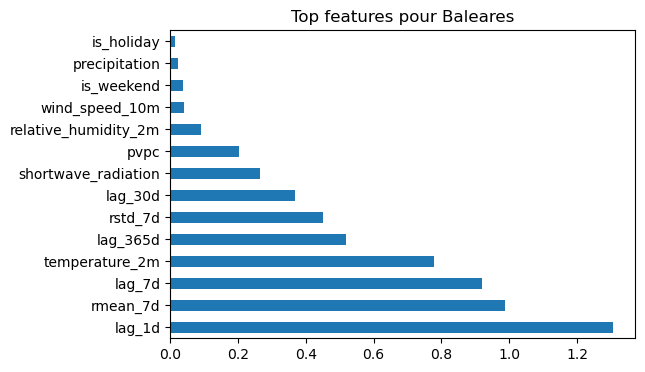

In [33]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_daily.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

## 8. Boucle complète et export final

In [40]:
# pipeline feature engineering et sauvegarde processed
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_hourly.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    # on peut garder les features de la liste ci-dessous
    features_to_keep = select_features(df, top_k= 14).index.tolist() 
    features_to_keep += ["demand", "pvpc", "temperature_2m"]
    
    features_to_keep = list(set(features_to_keep))

    # on ne garde que les features sélectionnées
    df = df[features_to_keep]

    # Export final en Parquet
    out_path = processed_dir/f"{zone}_processed_hourly.parquet"
    df.to_parquet(out_path, index=True)
    print(f"   • saved {out_path.name}")


→ Feature engineering Baleares
   • saved Baleares_processed_hourly.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_hourly.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_hourly.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_hourly.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_hourly.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_hourly.parquet
→ Feature engineering La_Gomera
   • saved La_Gomera_processed_hourly.parquet
→ Feature engineering La_Palma
   • saved La_Palma_processed_hourly.parquet
→ Feature engineering Melilla
   • saved Melilla_processed_hourly.parquet
→ Feature engineering nacional
   • saved nacional_processed_hourly.parquet
→ Feature engineering Peninsule_Iberique
   • saved Peninsule_Iberique_processed_hourly.parquet
→ Feature engineering Tenerife
   • saved Tenerife_processed_hourly.parquet


In [41]:
# pipeline feature engineering et sauvegarde processed
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_daily.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    # on peut garder les features de la liste ci-dessous
    features_to_keep = select_features(df, top_k= 14).index.tolist() 
    features_to_keep += ["demand", "pvpc", "temperature_2m",
                          "relative_humidity_2m",
                          "shortwave_radiation", 'is_weekend', 'is_holiday']
    
    features_to_keep = list(set(features_to_keep))

    # on ne garde que les features sélectionnées
    df = df[features_to_keep]

    # Export final en Parquet
    out_path = processed_dir/f"{zone}_processed_daily.parquet"
    df.to_parquet(out_path, index=True)
    print(f"   • saved {out_path.name}")


→ Feature engineering Baleares
   • saved Baleares_processed_daily.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_daily.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_daily.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_daily.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_daily.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_daily.parquet
→ Feature engineering La_Gomera
   • saved La_Gomera_processed_daily.parquet
→ Feature engineering La_Palma
   • saved La_Palma_processed_daily.parquet
→ Feature engineering Melilla
   • saved Melilla_processed_daily.parquet
→ Feature engineering nacional
   • saved nacional_processed_daily.parquet
→ Feature engineering Peninsule_Iberique
   • saved Peninsule_Iberique_processed_daily.parquet
→ Feature engineering Tenerife
   • saved Tenerife_processed_daily.parquet


,temp_rmean_7,temperature_2m,lag_1d,temp_rmean_6,demand,is_holiday,is_weekend,shortwave_radiation,T_sq,temp_rmean_12,temp_rmean_14,lag_7d,temp_rmean_24,month,temp_rmean_3,temp_rmean_30,relative_humidity_2m,WindChill,rmean_7d
datetime,,,,,,,,,,,,,,,,,,,
2015-04-30 00:00:00+00:00,20.286905,15.000000,899.180,20.150000,899.180,1,0,0.0,225.000000,20.397569,20.521726,899.180,19.962153,4,17.883333,19.901528,94.000000,15.000000,11894.753857
2015-05-01 00:00:00+00:00,20.286905,18.537500,899.180,20.150000,12730.749,1,0,6978.0,343.638906,20.397569,20.521726,899.180,19.962153,5,17.883333,19.901528,73.458333,18.537500,11894.753857
2015-05-02 00:00:00+00:00,20.286905,20.112500,12730.749,20.150000,13273.908,0,1,7326.0,404.512656,20.397569,20.521726,899.180,19.962153,5,17.883333,19.901528,71.833333,20.112500,11894.753857
2015-05-03 00:00:00+00:00,20.286905,21.620833,13273.908,20.150000,12655.341,0,1,7407.0,467.460434,20.397569,20.521726,899.180,19.962153,5,20.090278,19.901528,58.250000,21.620833,11894.753857
2015-05-04 00:00:00+00:00,20.286905,23.454167,12655.341,20.150000,14319.014,0,0,7063.0,550.097934,20.397569,20.521726,899.180,19.962153,5,21.729167,19.901528,54.916667,23.454167,11894.753857
2015-05-05 00:00:00+00:00,20.286905,22.175000,14319.014,20.150000,14635.702,0,0,5275.0,491.730625,20.397569,20.521726,899.180,19.962153,5,22.416667,19.901528,63.708333,22.175000,11894.753857
2015-05-06 00:00:00+00:00,20.286905,21.108333,14635.702,21.168056,14749.383,0,0,6730.0,445.561736,20.397569,20.521726,899.180,19.962153,5,22.245833,19.901528,71.125000,21.108333,11894.753857
2015-05-07 00:00:00+00:00,20.951190,19.650000,14749.383,21.353472,14639.706,0,0,7495.0,386.122500,20.397569,20.521726,899.180,19.962153,5,20.977778,19.901528,66.541667,19.650000,13857.686143
2015-05-08 00:00:00+00:00,21.179167,20.133333,14639.706,21.356944,14705.771,0,0,7736.0,405.351111,20.397569,20.521726,12730.749,19.962153,5,20.297222,19.901528,68.250000,20.133333,14139.832143


lag_1d            1.305267
rmean_7d          0.986170
lag_7d            0.917214
temp_rmean_6      0.844200
temp_rmean_3      0.833915
temp_rmean_7      0.817841
temp_rmean_12     0.791967
T_sq              0.782893
WindChill         0.780970
temperature_2m    0.777152
dtype: float64

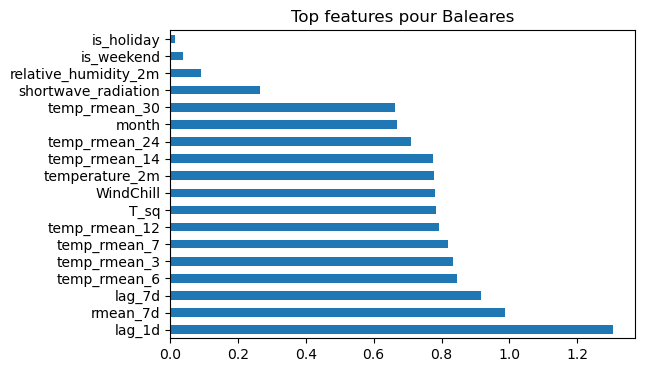

In [38]:
# Exemple d’affichage pour la première zone
df = pd.read_parquet(processed_dir/f"{zones[0]}_processed_daily.parquet")
mi_top = select_features(df)

display(df.head(10))
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

,dayofyear,temperature_2m,lag_168h,temp_rmean_3,lag_1h,T_sq,temp_rmean_30,hour,pvpc,temp_rmean_365,demand,CDD,temp_rmean_6,WindChill,rmean_7d,lag_24h
datetime,,,,,,,,,,,,,,,,
2015-04-30 22:00:00+00:00,120,15.0,472.871,15.000000,472.871,225.00,18.06,22,123.69,20.972877,472.871,0.0,15.000000,15.0,577.207208,472.871
2015-04-30 23:00:00+00:00,120,15.0,472.871,15.000000,472.871,225.00,18.06,23,114.06,20.972877,426.309,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 00:00:00+00:00,121,15.0,472.871,15.000000,426.309,225.00,18.06,0,113.99,20.972877,398.008,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 01:00:00+00:00,121,15.0,472.871,15.000000,398.008,225.00,18.06,1,115.40,20.972877,381.729,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 02:00:00+00:00,121,15.0,472.871,15.000000,381.729,225.00,18.06,2,111.10,20.972877,374.359,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 03:00:00+00:00,121,15.0,472.871,15.000000,374.359,225.00,18.06,3,111.03,20.972877,378.405,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 04:00:00+00:00,121,15.0,472.871,15.000000,378.405,225.00,18.06,4,111.55,20.972877,396.305,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 05:00:00+00:00,121,15.0,472.871,15.000000,396.305,225.00,18.06,5,110.06,20.972877,432.522,0.0,15.000000,15.0,577.207208,472.871
2015-05-01 06:00:00+00:00,121,15.6,472.871,15.200000,432.522,243.36,18.06,6,111.43,20.972877,508.352,0.0,15.100000,15.6,577.207208,472.871


lag_1h            1.598895
lag_24h           1.531515
lag_168h          1.197324
dayofyear         0.467063
rmean_7d          0.428868
WindChill         0.427787
T_sq              0.427524
temperature_2m    0.426948
temp_rmean_3      0.415630
temp_rmean_30     0.385535
dtype: float64

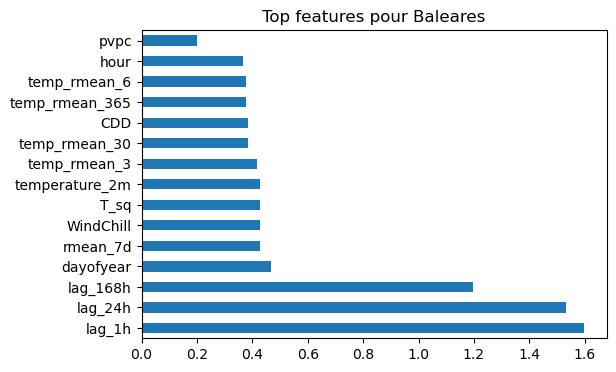

In [39]:
# Exemple d’affichage pour la première zone
df = pd.read_parquet(processed_dir/f"{zones[0]}_processed_hourly.parquet")
mi_top = select_features(df)

display(df.head(10))
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()